In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mcutils.scripts.MDE import fit_dispersion, micro_anisotropy
from mcutils.utils import spherical, sidecar
from scipy import optimize
from dipy.core import sphere
from dipy.data import get_sphere
from scipy import optimize
import seaborn as sns
import pandas as pd
from dataclasses import dataclass
from mcutils.plot import joint_density_scatter
sns.set()
sns.set_context('talk')

# Generating data

## B-shells

In [2]:
def get_bvecs(N):
    pos = np.random.randn(3, N)
    pos /= np.sqrt(sum(pos ** 2, 0))
    hemi = sphere.HemiSphere(*pos)
    new_hemi, pot = sphere.disperse_charges(hemi, 500)
    return new_hemi.vertices

In [3]:
bvecs_62 = get_bvecs(62)
single_LTE = lambda b: (bvecs_62[:, None, :] * bvecs_62[:, :, None]) * b
bvecs_50 = get_bvecs(50)
single_LSTE = lambda b: b * np.concatenate(
    (bvecs_50[:, None, :] * bvecs_50[:, :, None],
    [np.eye(3) / 3] * 12), axis=0
)
bvecs_31 = get_bvecs(31)
mat_31 = (bvecs_31[:, None, :] * bvecs_31[:, :, None])
multi_LTE = lambda b: np.concatenate((b * mat_31, b * 2 * mat_31), axis=0)

## Generate the data

In [4]:
@dataclass
class Tissue(object):
    volume_fraction: float
    d_axial: float
    d_radial: float

    @property
    def MD(self, ):
        return (self.d_axial + self.d_radial * 2) / 3

    @property
    def micro_anisotropy(self, ):
        return self.d_axial - self.d_radial

    def signal(self, bmat, bingham):
        bval = np.trace(bmat, axis1=1, axis2=2)
        anisotropy_signal = fit_dispersion.stick_dispersion(self.d_axial - self.d_radial, bmat, bingham)
        return self.volume_fraction * np.exp(-bval * self.d_radial) * anisotropy_signal


class Generator(object):
    def __init__(self, tissues, log_k1, log_k2):
        self.tissues = tissues
        self.log_k1 = log_k1
        self.log_k2 = log_k2

    @property
    def dispersion(self, ):
        return tuple(fit_dispersion.calc_dispersion(np.exp(lk)) for lk in (self.log_k1, self.log_k2))

    def bingham(self, ):
        return fit_dispersion.bingham_matrix(self.log_k1, self.log_k2, 0, 0, 0)

    def __call__(self, bmat, noise=0, rician=False):
        bmat = np.asarray(bmat)
        assert np.sum([t.volume_fraction for t in self.tissues]) == 1
        S = np.zeros(bmat.shape[0])
        bingham = self.bingham()
        for t in self.tissues:
            S += t.signal(bmat, bingham)
        S += np.random.randn(bmat.shape[0]) * noise
        if rician:
            S2 = np.random.randn(bmat.shape[0]) * noise
            S = np.sqrt(S ** 2 + S2 ** 2)
        return S

    def micro_anisotropy(self, b_value, b_delta=0):
        total = np.sum([t.volume_fraction * np.exp(-t.MD * b_value) * micro_anisotropy.mean_signal(t.micro_anisotropy * b_value, b_delta) * t.micro_anisotropy for t in self.tissues])
        norm = np.sum([t.volume_fraction * np.exp(-t.MD * b_value) * micro_anisotropy.mean_signal(t.micro_anisotropy * b_value, b_delta) for t in self.tissues])
        return total / norm

    def set_volume_fraction(self, f):
        self.tissues[0].volume_fraction = f
        self.tissues[1].volume_fraction = 1 - f
        
single_tissue = Generator([Tissue(1., 1.7, 0.)], 0.73, 1.89)

#csf = Tissue(0.2, 3., 3.)
intra_axonal = Tissue(0.5, 1.7, 0.)
extra_axonal_same_diso = Tissue(0.5, 1.1, 0.3)
extra_axonal_diff_diso = Tissue(0.5, 1.7, 0.9)
multi_tissue_same_diso = Generator([intra_axonal, extra_axonal_same_diso], 0.73, 1.89)
multi_tissue_diff_diso = Generator([intra_axonal, extra_axonal_diff_diso], 0.73, 1.89)
multi_tissue_same_diso.dispersion

(array(40.06563323), array(19.99053138))

In [5]:
def fa(l1, l2, l3):
    lv = np.array([l1, l2, l3])
    lm = lv.mean()
    return np.sqrt(1.5 * np.sum((lv - lm) ** 2) / np.sum(lv ** 2))
print(
    'intra:', fa(1.7, 0, 0),
    '\nextra (same d_iso)', fa(1.1, 0.3, 0.3),
    '\nextra (different d_iso)', fa(1.7, 0.9, 0.9),
)

intra: 1.0 
extra (same d_iso) 0.6785511437439768 
extra (different d_iso) 0.37670528747840887


In [6]:
name_maps = {
    'disp': r'mean dispersion ($^{\circ}$)',
    'disp1': r'minor dispersion ($^{\circ}$)',
    'disp2': r'major dispersion ($^{\circ}$)',
    'anisotropy': 'microscopic anisotropy\n' + r'($d_{\parallel} - d_{\perp}$ in ${\rm \mu}$m/ms$^2$)',
    'Sbase': r'$S_0 e^{-b d_{\rm iso}}$',
    'MDprime': r'MD - $\log(S_0) / b$',
}

# Mean signal trend with b-value

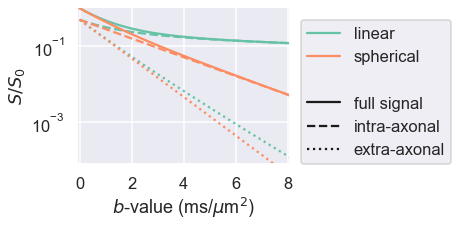

In [7]:
from matplotlib.lines import Line2D
sns.set_context('talk')
with sns.color_palette(sns.color_palette("Set2")):
    fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
    custom_lines = []
    for modality, color in (('LTE', 'C0'), ('STE', 'C1')):
        if modality == 'LTE':
            bmat = single_LTE(1.)
        else:
            bmat = np.asarray([np.eye(3) / 3])
        bval_list = np.linspace(0, 12, 121)
        Smean = [multi_tissue_diff_diso(bmat * bval, noise=0).mean() for bval in bval_list]

        custom_lines.append(ax.plot(bval_list, Smean, label=modality)[0])
        bingham = multi_tissue_diff_diso.bingham()
        for tissue, line_style in zip((intra_axonal, extra_axonal_diff_diso), ('--', ':')):
            Smean = [tissue.signal(bmat * bval, bingham=bingham).mean() for bval in bval_list]
            ax.plot(bval_list, Smean, linestyle=line_style, color=custom_lines[-1].get_color())
    ax.set_xlabel('$b$-value (ms/$\mu$m$^2$)')
    ax.set_ylabel('$S/S_0$')
    ax.set_yscale('log')
    ax.set_ylim(0.00008, 1.1)
    custom_lines.extend([
                    Line2D([0], [0], alpha=0,),
                    Line2D([0], [0], color='k', linestyle='-'),
                    Line2D([0], [0], color='k', linestyle='--'),
                    Line2D([0], [0], color='k', linestyle=':')
    ])
    ax.legend(custom_lines, ['linear', 'spherical', '', 'full signal', 'intra-axonal', 'extra-axonal'],
             ncol=1, loc=(1.05, 0.))
    ax.set_xlim(-0.1, 8.1)
    ax.set_xticks([0, 2, 4, 6, 8])
    fig.tight_layout()
    fig.subplots_adjust(right=0.6)
#fig.savefig('relative_signal.png')

# Bias plots 

In [ ]:
%%time
# This code block regenerates the file 'multi_tissue_bias_rician.csv'
# If the file already exists, this block can be skipped
# It takes ~20 minutes to run on my computer

volume_fraction = (0, 0.25, 0.5, 0.75, 1)
nrepeat = 500
df_list = []
for vf in volume_fraction:
    for mt_name, multi_tissue in (
        ('same d_iso', multi_tissue_same_diso), 
        ('different d_iso', multi_tissue_diff_diso)
    ):
        for name, bmat in [
            ('multi-shell linear', multi_LTE(1.5)),
            ('single-shell linear', single_LTE(1.5)),
            ('linear & spherical', single_LSTE(1.5)),
        ]:
            signal = np.zeros((nrepeat, bmat.shape[0]))
            multi_tissue.set_volume_fraction(vf)
            for idx in range(nrepeat):
                signal[idx] = multi_tissue(bmat, noise=1./30., rician=True)
            acq = sidecar.AcquisitionParams(btensor=bmat * 1e3)
            _, df_res = fit_dispersion.run(signal, acq, include_S0=False, ncoils=1)
            df_res['bmat'] = name
            df_res['multi_tissue'] = mt_name
            df_res['bval'] = 1.5
            df_res['volume_fraction'] = vf
            if 'single-shell linear & spherical' == name:
                df_res['ratio_anisotropy'] = micro_anisotropy.run_single_shell(signal.T, np.append(np.ones(75), np.zeros(75)))[0] / 2
            else:
                df_res['ratio_anisotropy'] = 0
            df_res.anisotropy *= 1e3
            df_res.MDprime *= 1e3
            df_list.append(df_res)
df_bias = pd.concat(df_list).reset_index()
df_bias['disp'] = (df_bias.disp1 + df_bias.disp2) / 2
df_bias['Sbase'] = np.exp(-1.5 * df_bias['MDprime'])
df_bias.to_csv('multi_tissue_bias_rician.csv')
df_bias

In [8]:
df_bias = pd.read_csv('multi_tissue_bias_rician.csv')
order = ('single-shell linear',  'multi-shell linear', 'linear & spherical')

In [9]:
def qrange(x):
    return np.percentile(x, 75) - np.percentile(x, 25)
mean_range = df_bias.groupby(('bmat', 'multi_tissue', 'volume_fraction')).agg((np.mean, qrange))
mean_range

/usr/local/Caskroom/miniconda/base/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


Unnamed: 0         index  \
                                                          mean qrange   mean   
bmat                multi_tissue    volume_fraction                            
linear & spherical  different d_iso 0.00                2749.5  249.5  249.5   
                                    0.25                5749.5  249.5  249.5   
                                    0.50                8749.5  249.5  249.5   
                                    0.75               11749.5  249.5  249.5   
                                    1.00               14749.5  249.5  249.5   
                    same d_iso      0.00                1249.5  249.5  249.5   
                                    0.25                4249.5  249.5  249.5   
                                    0.50                7249.5  249.5  249.5   
                                    0.75               10249.5  249.5  249.5   
                                    1.00               13249.5  249.5  249.5   
multi-shell linear  different d_iso 0.00                1749.5  249.5  249.5   
                                    0.25                4749.5  249.5  249.5   
                                    0.50                7749.5  249.5  249.5   
                                    0.75               10749.5  249.5  249.5   
                                    1.00               13749.5  249.5  249.5   
                    same d_iso      0.00                 249.5  249.5  249.5   
                                    0.25                3249.5  249.5  249.5   
                                    0.50                6249.5  249.5  249.5   
                                    0.75                9249.5  249.5  249.5   
                                    1.00               12249.5  249.5  249.5   
single-shell linear different d_iso 0.00                2249.5  249.5  249.5   
                                    0.25                5249.5  249.5  249.5   
                                    0.50                8249.5  249.5  249.5   
                                    0.75               11249.5  249.5  249.5   
                                    1.00               14249.5  249.5  249.5   
                    same d_iso      0.00                 749.5  249.5  249.5   
                                    0.25                3749.5  249.5  249.5   
                                    0.50                6749.5  249.5  249.5   
                                    0.75                9749.5  249.5  249.5   
                                    1.00               12749.5  249.5  249.5   

                                                                 phi  \
                                                    qrange      mean   
bmat                multi_tissue    volume_fraction                    
linear & spherical  different d_iso 0.00             249.5  0.027734   
                                    0.25             249.5  0.112955   
                                    0.50             249.5 -0.139599   
                                    0.75             249.5  0.038502   
                                    1.00             249.5 -0.019580   
                    same d_iso      0.00             249.5 -0.192704   
                                    0.25             249.5  0.050784   
                                    0.50             249.5 -0.107836   
                                    0.75             249.5 -0.201449   
                                    1.00             249.5 -0.147825   
multi-shell linear  different d_iso 0.00             249.5 -0.007561   
                                    0.25             249.5  0.083852   
                                    0.50             249.5 -0.054858   
                                    0.75             249.5  0.057159   
                                    1.00             249.5 -0.132919   
                    same d_iso      0.00             249.5  0.100858   
                                    0.25   

different d_iso
same d_iso


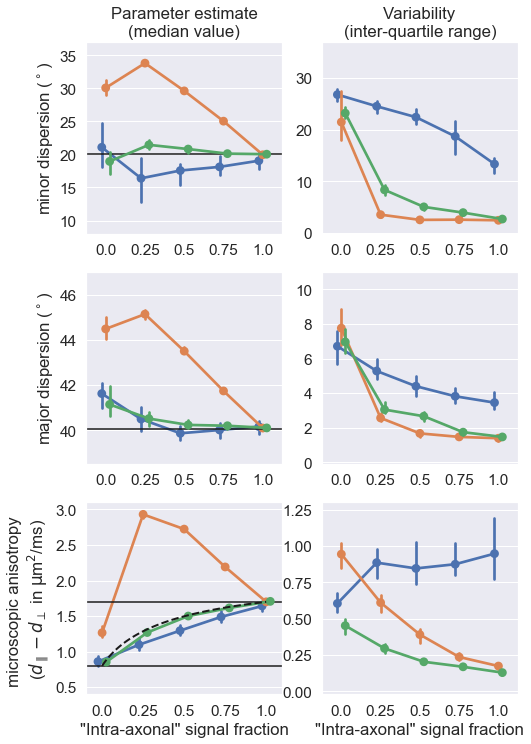

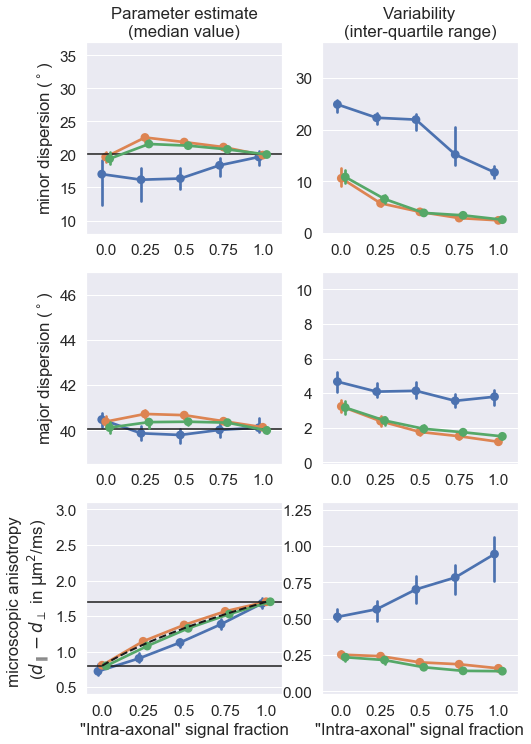

In [10]:
def qrange(x):
    return np.percentile(x, 75) - np.percentile(x, 25)
sns.set_context('notebook', font_scale=1.4)
#sns.catplot('bval', 'disp1', hue='bmat', ax=axes[0], data=df_bias, kind='point')
pallette = ['']
for mt, df_mt in df_bias.groupby('multi_tissue'):
    print(mt)
    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    sns.pointplot('volume_fraction', 'disp1', hue='bmat', ax=axes[0, 0], dodge=0.2, estimator=np.median, data=df_mt,
                 hue_order=order)
    sns.pointplot('volume_fraction', 'disp1', hue='bmat', ax=axes[0, 1], dodge=0.2, estimator=qrange, data=df_mt,
                 hue_order=order)
    sns.pointplot('volume_fraction', 'disp2', hue='bmat', ax=axes[1, 0], dodge=0.2, estimator=np.median, data=df_mt,
                 hue_order=order)
    sns.pointplot('volume_fraction', 'disp2', hue='bmat', ax=axes[1, 1], dodge=0.2, estimator=qrange, data=df_mt,
                 hue_order=order)
    sns.pointplot('volume_fraction', 'anisotropy', hue='bmat', ax=axes[2, 0], dodge=0.2, estimator=np.median, data=df_mt,
                 hue_order=order)
    sns.pointplot('volume_fraction', 'anisotropy', hue='bmat', ax=axes[2, 1], dodge=0.2, estimator=qrange, data=df_mt,
                 hue_order=order)
    #sns.boxplot('bval', 'anisotropy', hue='bmat', ax=axes[0, 1], data=df_bias)#, ci='sd', dodge=0.2, estimator=np.median)

    # true values
    multi_tissue = multi_tissue_same_diso if mt == 'same d_iso' else multi_tissue_diff_diso
    extra_axonal = multi_tissue.tissues[1]
    axes[0, 0].axhline(min(multi_tissue.dispersion), color='k')
    axes[1, 0].axhline(max(multi_tissue_same_diso.dispersion), color='k')
    for t in multi_tissue_same_diso.tissues:
        axes[2, 0].axhline(t.micro_anisotropy, color='k')
    bvals = np.unique(df_bias.bval)
    #axes[1].plot([multi_tissue.micro_anisotropy(b, b_delta=0) for b in bvals], 'k*')
    #axes[1].plot([multi_tissue.micro_anisotropy(b, b_delta=1) for b in bvals], 'w*')

    for ax in axes.flatten():
        ax.get_legend().remove()
        ax.set_xlabel('"Intra-axonal" signal fraction')

    axes[0, 0].set_ylabel('minor dispersion ($^\circ$)')
    axes[1, 0].set_ylabel('major dispersion ($^\circ$)')
    axes[2, 0].set_ylabel('microscopic anisotropy \n($d_\\parallel - d_{\\perp}$ in ${\\rm \\mu}$m$^2$/ms)')
    axes[0, 0].set_title('Parameter estimate\n(median value)')
    axes[0, 1].set_title('Variability\n(inter-quartile range)')

    for idx in range(3):
        axes[idx, 1].set_ylabel('')
    for idx in range(2):
        axes[0, idx].set_xlabel('')
        axes[1, idx].set_xlabel('')
        
    axes[0, 0].set_ylim(8, 37)
    axes[0, 1].set_ylim(-0.2, 37)
    axes[1, 0].set_ylim(38.5, 47)
    axes[1, 1].set_ylim(-0.1, 11)
    axes[2, 0].set_ylim(0.4, 3.1)
    axes[2, 1].set_ylim(-0.02, 1.3)

    vf = np.linspace(0, 1, 101)
    STE_signal = [vf * np.exp(-1.5 * multi_tissue.tissues[0].MD), (1 - vf) * np.exp(-1.5 * multi_tissue.tissues[1].MD)]               
    weight = np.asarray(STE_signal) / np.sum(STE_signal, 0)[None, :]
    weighted_ma2 = np.sqrt((weight * np.array([t.micro_anisotropy ** 2 for t in multi_tissue.tissues])[:, None]).sum(0))
    axes[2, 0].plot(vf * 4, weighted_ma2, 'k--', lw=2, zorder=3)
    fig.subplots_adjust(left=0.15)
    #fig.savefig(f'bias_{mt.replace(" ", "_")}.png')    
    

# Look at distribution

## Full joint plot

0.5666666666666667
(array(19.99053138), array(40.06563323), 1.7, 0.21370746597436335)
1.1666666666666667
(array(19.99053138), array(40.06563323), 0.7999999999999999, 0.08688697172522257)


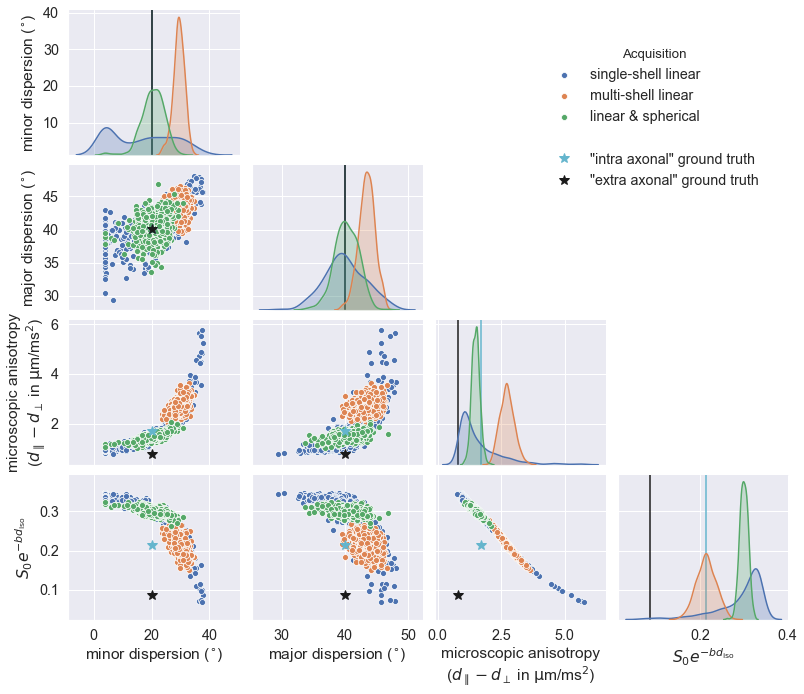

In [11]:
from matplotlib.lines import Line2D
def full_joint(vf, mt):
    sns.set_context('notebook', font_scale=1.3)
    df_bias_single = df_bias[(df_bias.volume_fraction == vf) & (df_bias.multi_tissue == mt + ' d_iso') & (df_bias.anisotropy < 10)]
    grid = sns.pairplot(df_bias_single.rename(columns=name_maps), hue='bmat', hue_order=order,
                        vars=[name_maps[name] for name in ('disp1', 'disp2', 'anisotropy', 'Sbase')])
    grid._legend.remove()
    data = dict(grid._legend_data)
    data[''] = Line2D([0], [0], alpha=0)
    extra_axonal = extra_axonal_same_diso if mt == 'same' else extra_axonal_diff_diso
    for tissue_name, color, tissue_vf, tissue in zip(('intra_axonal', 'extra_axonal'), ('c', 'k'), (vf, 1 - vf),
                                            (intra_axonal, extra_axonal)):
        if tissue_vf == 0.:
            continue
        print(tissue.MD)
        true_params = multi_tissue_same_diso.dispersion[::-1] + (tissue.micro_anisotropy, tissue_vf * np.exp(-1.5 * tissue.MD))
        print(true_params)
        data[f'"{tissue_name.replace("_", " ")}" ground truth'] = Line2D([0], [0], color=color, linestyle='', marker='*', ms=10)
        for idx1, p1 in enumerate(true_params):
            for idx2, p2 in enumerate(true_params):
                if idx1 > idx2:
                    grid.axes[idx1, idx2].plot(p2, p1, color + '*', ms=10)
                elif idx1 == idx2:
                    ax = grid.axes[idx1, idx2]
                    ylim = ax.get_ylim()
                    ax.axvline(p2, color=color)
                    ax.set_ylim(ylim)
                elif color == 'c':
                    grid.axes[idx1, idx2].remove()
    plt.subplots_adjust(hspace=0.07, wspace=0.07)
    grid.add_legend(data, 'Acquisition', list(data.keys()))
    grid._legend.set_bbox_to_anchor((0.7, 0.8))

full_joint(0.5, 'different')

0.5666666666666667
(array(19.99053138), array(40.06563323), 1.7, 0.21370746597436335)
0.5666666666666668
(array(19.99053138), array(40.06563323), 0.8, 0.21370746597436333)


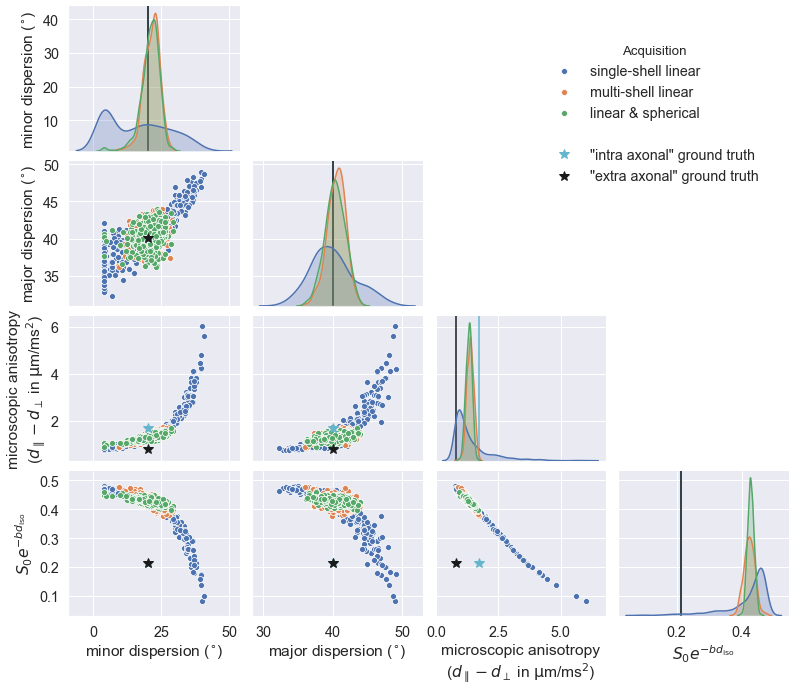

In [12]:
full_joint(0.5, 'same')

0.5666666666666667
(array(19.99053138), array(40.06563323), 1.7, 0.4274149319487267)


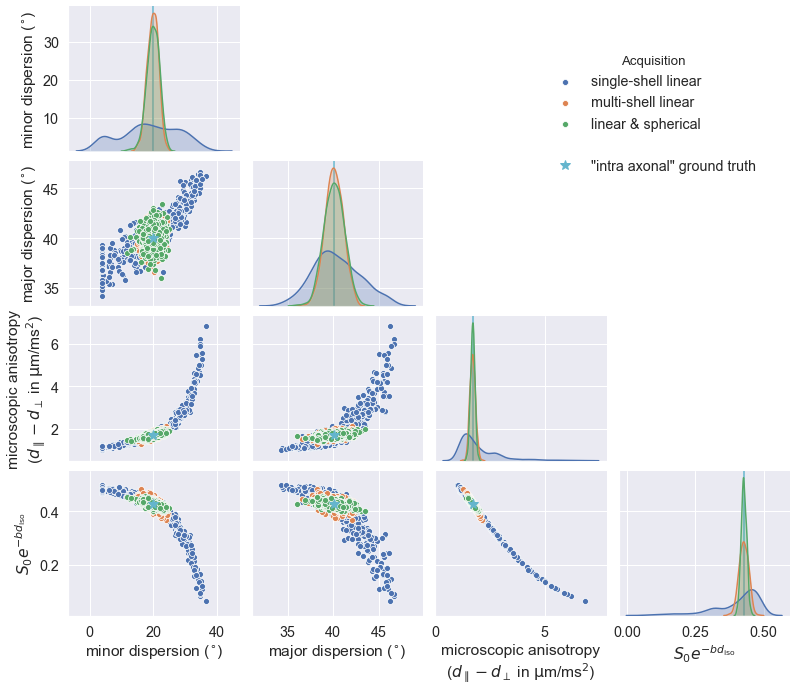

In [13]:
full_joint(1, 'different')

1.1666666666666667
(array(19.99053138), array(40.06563323), 0.7999999999999999, 0.17377394345044514)


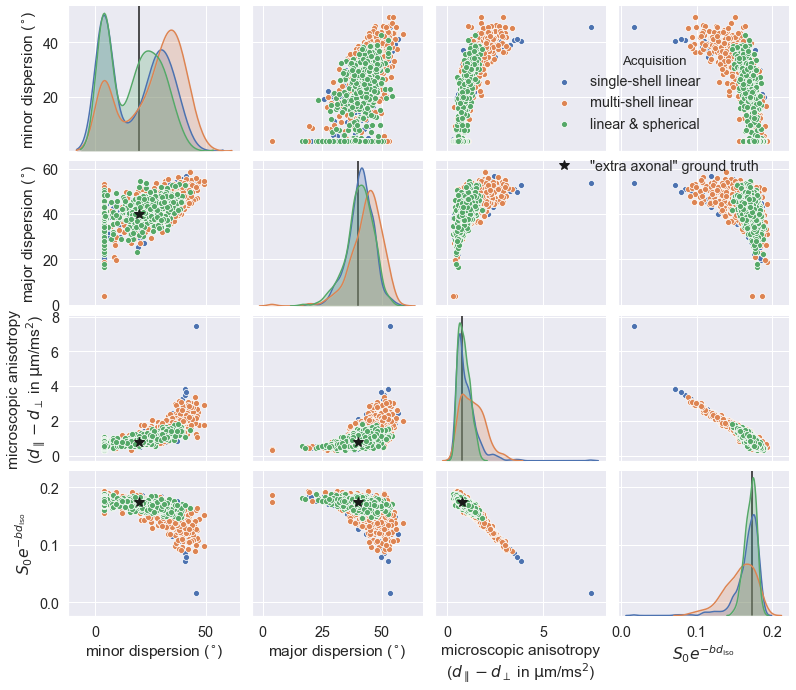

In [14]:
full_joint(0, 'different')

## Separate different acquisitions

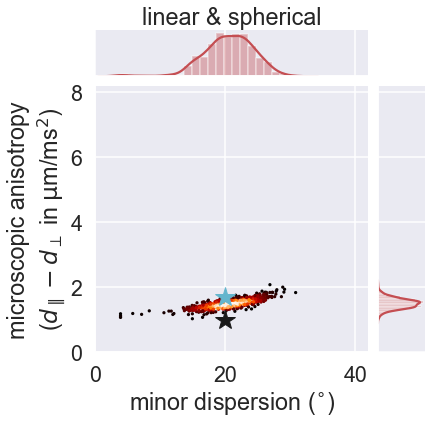

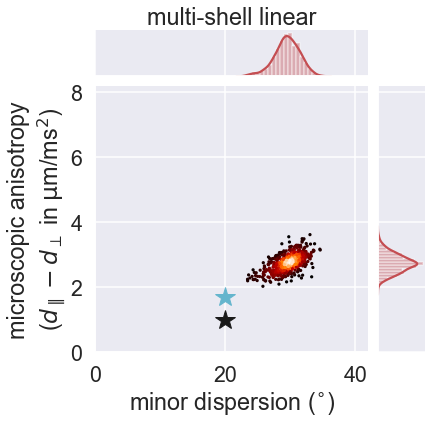

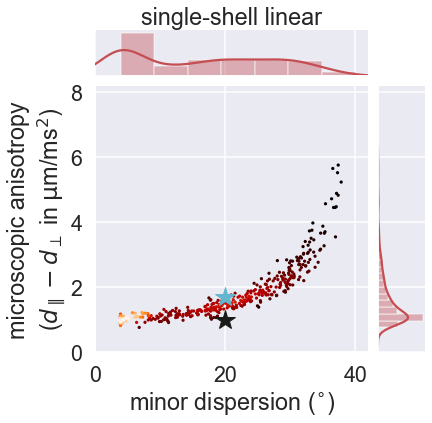

In [15]:
def plot_panels(vf, mt='same'):
    df_bias_single = df_bias[(df_bias.volume_fraction == vf) & (df_bias.multi_tissue == mt + ' d_iso')]
    sns.set_context('talk', font_scale=1.3)
    for acq, df_acq in df_bias_single.groupby('bmat'):
        g = joint_density_scatter(df_acq.disp1, df_acq.anisotropy, s=3, xlim=(0, 42), ylim=(0, 8.2))
        g.ax_joint.plot(min(multi_tissue_same_diso.dispersion), 1, 'k*', ms=20)
        g.ax_joint.plot(min(multi_tissue_same_diso.dispersion), intra_axonal.micro_anisotropy, 'c*', ms=20)
        g.ax_joint.set_xlabel('')
        g.ax_joint.set_ylabel('')
        g.ax_marg_x.set_title(acq)
        g.ax_joint.set_xlabel(name_maps['disp1'])
        g.ax_joint.set_ylabel(name_maps['anisotropy'])
        
plot_panels(0.5, 'different') 

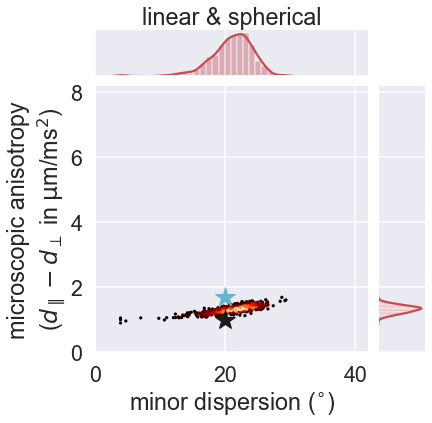

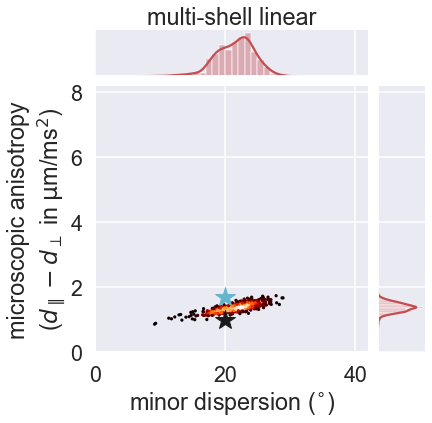

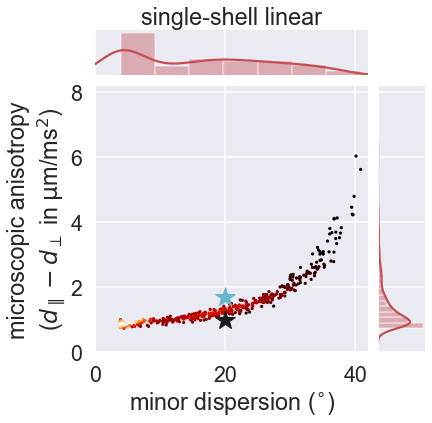

In [16]:
plot_panels(0.5, 'same')


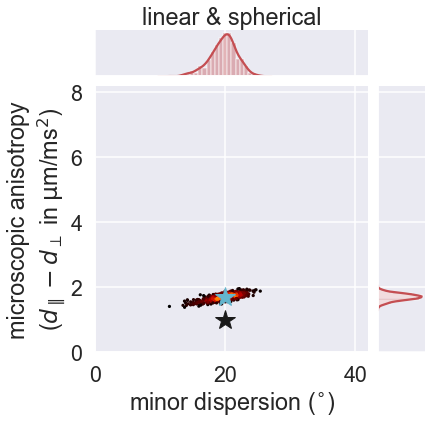

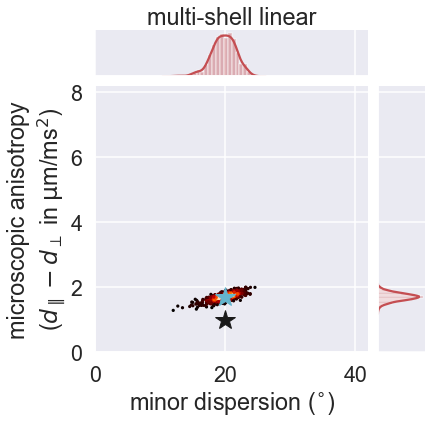

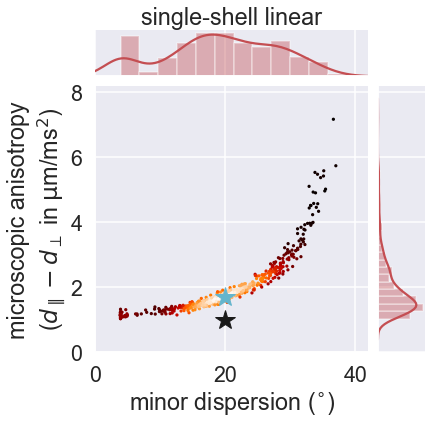

In [17]:
plot_panels(1, 'same') 


# Bias as a function of b-value

In [ ]:
%%time
# This code block regenerates the file 'multi_tissue_bval_bias_rician.csv'
# If the file already exists, this block can be skipped
# It takes ~30 minutes to run on my computer
bvals = (0.5, 1., 1.5, 2., 2.5, 3.)
nrepeat = 500
df_list = []
for bval in bvals:
    for mt_name, multi_tissue in (
        ('same d_iso', multi_tissue_same_diso), 
        ('different d_iso', multi_tissue_diff_diso)
    ):
        for name, bmat in [
            ('multi-shell linear', multi_LTE(bval)),
            ('single-shell linear', single_LTE(bval)),
            ('linear & spherical', single_LSTE(bval)),
        ]:
            signal = np.zeros((nrepeat, bmat.shape[0]))
            multi_tissue.set_volume_fraction(0.5)
            for idx in range(nrepeat):
                signal[idx] = multi_tissue(bmat, noise=1./30., rician=True)
            acq = sidecar.AcquisitionParams(btensor=bmat * 1e3)
            _, df_res = fit_dispersion.run(signal, acq, include_S0=False, ncoils=1)
            df_res['bmat'] = name
            df_res['multi_tissue'] = mt_name
            df_res['bval'] = bval
            df_res['volume_fraction'] = 0.5
            if 'single-shell linear & spherical' == name:
                df_res['ratio_anisotropy'] = micro_anisotropy.run_single_shell(signal.T, np.append(np.ones(75), np.zeros(75)))[0] / 2
            else:
                df_res['ratio_anisotropy'] = 0
            df_res.anisotropy *= 1e3
            df_res.MDprime *= 1e3
            df_list.append(df_res)
df_bias = pd.concat(df_list).reset_index()
df_bias['disp'] = (df_bias.disp1 + df_bias.disp2) / 2
df_bias['Sbase'] = np.exp(-df_bias['bval'] * df_bias['MDprime'])
df_bias.to_csv('multi_tissue_bval_bias_rician.csv')
df_bias


In [18]:
df_bias = pd.read_csv('multi_tissue_bval_bias_rician.csv')
order = ('single-shell linear',  'multi-shell linear', 'linear & spherical')


different d_iso
same d_iso


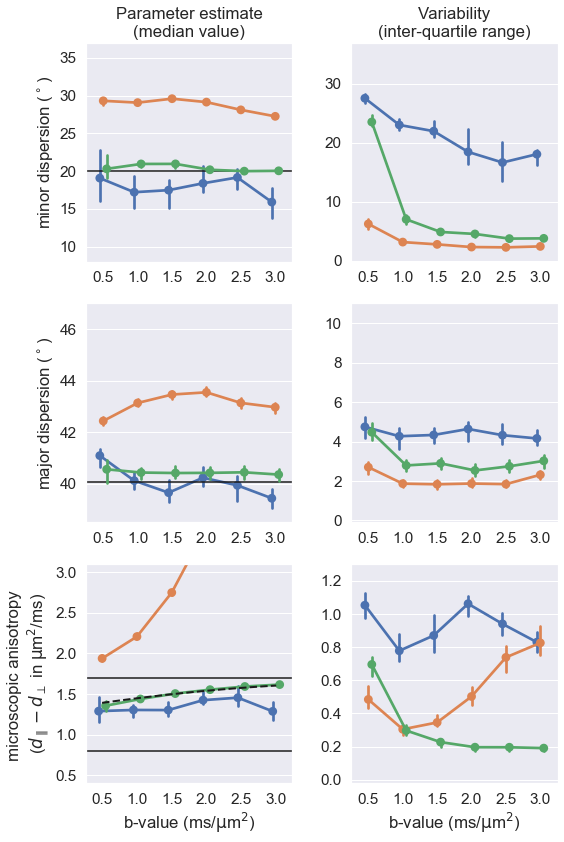

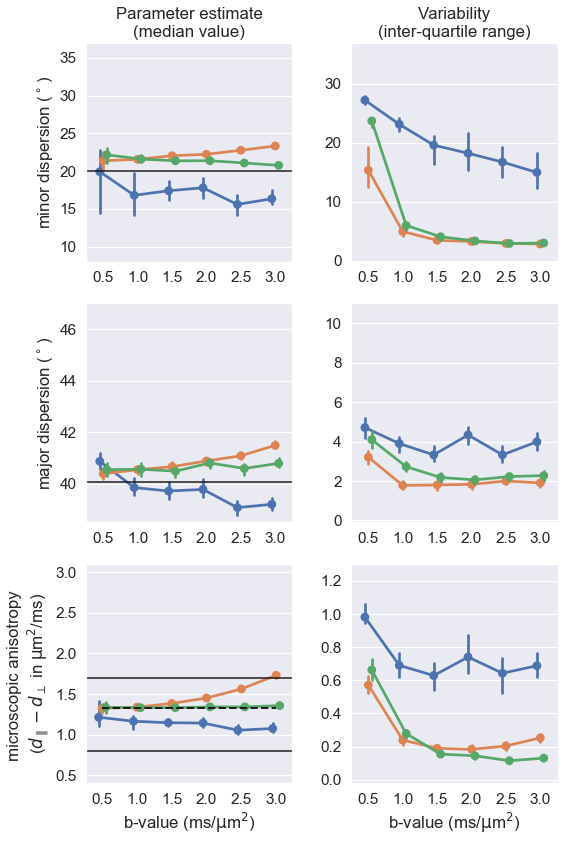

In [19]:
def qrange(x):
    return np.percentile(x, 75) - np.percentile(x, 25)
sns.set_context('notebook', font_scale=1.4)

pallette = ['']
for mt, df_mt in df_bias.groupby('multi_tissue'):
    print(mt)
    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    sns.pointplot('bval', 'disp1', hue='bmat', ax=axes[0, 0], dodge=0.2, estimator=np.median, data=df_mt,
                 hue_order=order)
    sns.pointplot('bval', 'disp1', hue='bmat', ax=axes[0, 1], dodge=0.2, estimator=qrange, data=df_mt,
                 hue_order=order)
    sns.pointplot('bval', 'disp2', hue='bmat', ax=axes[1, 0], dodge=0.2, estimator=np.median, data=df_mt,
                 hue_order=order)
    sns.pointplot('bval', 'disp2', hue='bmat', ax=axes[1, 1], dodge=0.2, estimator=qrange, data=df_mt,
                 hue_order=order)
    sns.pointplot('bval', 'anisotropy', hue='bmat', ax=axes[2, 0], dodge=0.2, estimator=np.median, data=df_mt,
                 hue_order=order)
    sns.pointplot('bval', 'anisotropy', hue='bmat', ax=axes[2, 1], dodge=0.2, estimator=qrange, data=df_mt,
                 hue_order=order)

    # true values
    multi_tissue = multi_tissue_same_diso if mt == 'same d_iso' else multi_tissue_diff_diso
    extra_axonal = multi_tissue.tissues[1]
    axes[0, 0].axhline(min(multi_tissue.dispersion), color='k')
    axes[1, 0].axhline(max(multi_tissue_same_diso.dispersion), color='k')
    for t in multi_tissue_same_diso.tissues:
        axes[2, 0].axhline(t.micro_anisotropy, color='k')
    bvals = np.unique(df_bias.bval)

    for ax in axes.flatten():
        ax.get_legend().remove()
        ax.set_xlabel('b-value (ms/${\\rm \\mu}$m$^2$)')

    axes[0, 0].set_ylabel('minor dispersion ($^\circ$)')
    axes[1, 0].set_ylabel('major dispersion ($^\circ$)')
    axes[2, 0].set_ylabel('microscopic anisotropy \n($d_\\parallel - d_{\\perp}$ in ${\\rm \\mu}$m$^2$/ms)')
    axes[0, 0].set_title('Parameter estimate\n(median value)')
    axes[0, 1].set_title('Variability\n(inter-quartile range)')

    for idx in range(3):
        axes[idx, 1].set_ylabel('')
    for idx in range(2):
        axes[0, idx].set_xlabel('')
        axes[1, idx].set_xlabel('')
        
    axes[0, 0].set_ylim(8, 37)
    axes[0, 1].set_ylim(-0.2, 37)
    axes[1, 0].set_ylim(38.5, 47)
    axes[1, 1].set_ylim(-0.1, 11)
    axes[2, 0].set_ylim(0.4, 3.1)
    axes[2, 1].set_ylim(-0.02, 1.3)

    bvals = np.linspace(0.5, 3., 101)
    vf = 0.5
    STE_signal = [vf * np.exp(-bvals * multi_tissue.tissues[0].MD), (1 - vf) * np.exp(-bvals * multi_tissue.tissues[1].MD)]               
    weight = np.asarray(STE_signal) / np.sum(STE_signal, 0)[None, :]
    weighted_ma = np.sqrt((weight * np.array([t.micro_anisotropy ** 2 for t in multi_tissue.tissues])[:, None]).sum(0))
    axis_bvals = np.linspace(0, 5, 101)
    axes[2, 0].plot(axis_bvals, weighted_ma, 'k--', lw=2, zorder=3)
    fig.tight_layout()
    fig.subplots_adjust(left=0.15)
    #fig.savefig(f'bias_bval_{mt.replace(" ", "_")}.png')    
